# Part 4

In [1]:
import numpy as np
np.random.seed(16)

import sklearn
from sklearn import datasets

import optilibrary as ot

## Setting up a convex problem

A general equation of a paraboloid is stated with three terms:
$$P(x) = x^{T}Ax + Cx + d $$ 
where A is positive definite, $A \in \mathbb{R}^{n\times{n}} \succ{0}$, $C\in\mathbb{R}^{n}$, and $d\in\mathbb{R}$

In [2]:
dim = 2
#Generate problem
# A = datasets.make_spd_matrix(dim, random_state=16)
# A = A

A = np.array([[2, 0],[0, 3]]) #np.random.uniform(0, 1, dim)
B = np.array([5, 6])#B/np.sum(B)

d = 0 # np.random.uniform(-1, 0,1)

#Functions
# P = lambda x: x.T.dot(x.T.dot(A)) + B.dot(x) + d
# gradP = lambda x: 2*A.dot(x) + B

print(A, B, d, sep='\n')
print(np.linalg.eigvals(A))

[[2 0]
 [0 3]]
[5 6]
0
[2. 3.]


#### For projected gradient descent, the problem may be formulated as follows:
$$ \min_{x\in K} P(x) \text{    s.t.   } ||{x}||\leq{R} $$

where $K$ is a convex set. The gradient writes as 
$$\nabla{P} = 2Ax + C$$

For this project we consider 3 different convex sets.
- If $K$ is the $\ell_2$-ball, the projection may be expressed as:
 $$\Pi_{A}(x) = \frac{R}{max(||x||_2, R)}x$$ 
- Projection onto the simplex with sum R
- Projection onto the $\ell_1$-ball with radius R

The last 2 projections have algorithms proposed by Laurent Condat in his paper _Fast Projection onto the Simplex and the l1 Ball_




_(See Laurent Condat. Fast Projection onto the Simplex and the l1 Ball. Mathematical Programming, Series A, 2016, 158 (1), pp.575-585. ￿10.1007/s10107-015-0946-6. hal-01056171v2)_

#### For the Franke-Wolfe / Conditional gradient
When the convex set $K$ is the $\ell_2$-ball with radius R, we wish to solve:

\begin{equation}\tag{1}
s_{k+1} \in \underset{s \in B(0,R)}{\mathrm{argmin}} \big\{ f(x_k) + \langle\ \nabla f(x_k), s - x_k \rangle\ \big\}
\end{equation}

which is known to have explicit solution:
\begin{equation}\tag{2}
s_{k+1,j} = - R \frac{\text{sign}(\nabla f_j(x_k))|\nabla f_j(x_k)|}{||\nabla f(x_k)||_2}
\end{equation}
The weighting of the convex combination may be determined by exact linesearch:
\begin{equation}\tag{3}
\theta_k \in \argmin_{\theta\in{[0,1]}} f(\theta_k s_{k+1} + (1-\theta) x_k)
\end{equation}

or by making use of a prescribed step size such as 
\begin{equation}\tag{4}
\theta_k = \frac{2}{k+2}
\end{equation}

We choose an arbitrary starting point $x_0$ on the boundary of the $\ell_2$-ball with radius $R$ and run an iteration of PGD for the $\ell_2$-ball:

In [3]:
R = 2
maxiter = 1000
dim

2

In [4]:
def gradF(theta):
    return ( A.dot(theta) + B )

def F(x):
    return x.dot(A).dot(x) + B.dot(x) + d

def PGD(F, gradF, th0, step, niter, projectionfunction, R):
    iters = [th0]
    theta = th0
    for k in range(niter):
        g = gradF(th0)
        theta = projectionfunction( theta - step*g, R )
        iters.append(theta)
    return np.array(iters)

x0 = ot.extrpt(dim, R, 2)
print(np.linalg.norm(x0))
prule = lambda x, R: ot.project(2, x, R)
thstar = PGD(F, gradF, x0, 0.01, maxiter, prule, R)

2.0


For a problem of small dimension as here, we may determine the exact solution by making use of scipy's _optimize_ library. 
The optimal solution $x^*$ is:

In [5]:
from scipy.optimize import minimize
res = minimize(F, x0, method='nelder-mead', options={'xatol':1e-8}) 
res.x

array([-1.25, -1.  ])

Let us thus plot the evolution of iterations as a function of the true error: 
$$\| x^* - x_k\|_2$$


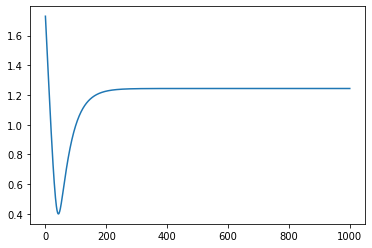

In [6]:
import matplotlib.pyplot as plt

errs = np.linalg.norm(thstar - res.x, ord=2, axis=1)
plt.plot(errs);

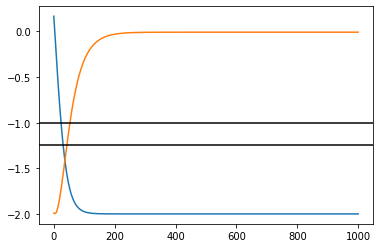

In [7]:
plt.plot(thstar);
for i in range(dim):
    plt.axhline(res.x[i], color='k', label='true')

In [8]:
# iters = []
# errs = []
# lball = [1, 2]
# tol=1e-20

# for l in lball:
#     proj_rule = lambda x, R: ot.project(l, x, R)
#     x = ot.project(l, x0, R)
#     it, e = ot.ProjGD_Ball(x, P, gradP, tol=tol, step=0.1, max_iter=maxiter, R=R, projectionfunction=proj_rule)
#     iters.append(it)
#     errs.append(e)
# # errs = np.array(errs)

#### Consider the errors

In [9]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.figure(figsize=(9,4), tight_layout=True)
# # plt.subplot(1,2,1)
# for i in errs:
#     plt.plot(np.log(i[1:120]))
# plt.legend(lball)
# # plt.plot(np.log(errs))
# plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$');
# # plt.subplot(1,2,2)
# # for i in errs:
# #     plt.plot(i[1:])
# # plt.legend(lball)
# # plt.title('Errors');


Let us consider the evolution of the parameters by plotting the true value of the solution in black and each projection in blue and red. We see that the iterates do indeed converge to the true value. 

In [10]:
l1iters = iters[0]
l2iters = iters[1]

# l1iters[:,::10]
plt.plot(l1iters[:,::10].T, color='b', label='l1-ball');
plt.plot(l2iters[:,::10].T, color='r', label='l2-ball');
for i in range(dim):
    plt.axhline(res.x[i], color='k', label='true')

plt.legend();


NameError: name 'iters' is not defined

For a problem in 2D, we may also actually sketch out the constraints and function to plot the iterates

In [11]:
n = 50
t = np.linspace(-2, 2, n)
X, Y = np.meshgrid(t,t)

In [12]:
iters = thstar.T
vals = np.zeros(iters.shape[1])
for i in range(iters.shape[1]):
    vals[i] = F(iters[:,i])

temp = np.zeros(n*n)
Z = np.vstack((X.ravel(), Y.ravel()))
for i in range(Z.shape[1]):
    temp[i] = (F(Z[0:2, i]))
    
temp = temp.reshape((n,n))

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [14]:
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = R*(np.cos(u) * np.sin(v))
y = R*(np.sin(u) * np.sin(v))
z = np.cos(v)*R

In [15]:
%matplotlib qt
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')
ax.scatter3D(iters[0,0], iters[1,0], vals[0], s=10, c='r', label='starting point')
ax.scatter3D(iters[0,1:], iters[1,1:], vals[1:], c='b', s=5, label='iterations of projected Gradient')
ax.plot_surface(X, Y, temp, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.1)
# ax.plot_wireframe(x, y, z, alpha=0.3, color='k')

#d=3
# ax.scatter3D(iters[1][0,0], iters[1][1,0], iters[1][2,0], s=5, c='r', label='starting point') #starting point
# ax.scatter3D(iters[1][0,1:], iters[1][1,1:], iters[1][2,1:], c='b', s=5, label='iterations of projected Gradient')

# ax.set_xlim(-R-R/10,R+R/10)
# ax.set_ylim(-R-R/10,R+R/10)
# ax.set_zlim(-R-R/10,R+R/10)
# ax.set_xlim(-2,0)
# ax.set_ylim(-2,2)
# ax.set_zlim(-0.5, 10)
ax.axis('off');
ax.legend();

In [ ]:
def rules(lball):
    theta_rule = lambda k, sk: ot.updatetheta('fixed', k, sk, f=P, gradf=gradP)
    extr_rule = lambda d, R: ot.extrpt(d, R, lball)
    argm_rule = lambda x, R: ot.argmin(x, R, lball)
    proj_rule = lambda x, R: ot.project(lball, x, R)

    return theta_rule, extr_rule, argm_rule, proj_rule

theta_rule, extr_rule, argm_rule, proj_rule = rules(lball=1)

maxit=100
R=0.75
step = 0.01
tol = 1e-20

iter_cond, err_cond = ot.CondGD(f=P, gradf=gradP, R=R, pick_theta_rule=theta_rule, extr_pt_rule=extr_rule, argminrule=argm_rule, dim=dim, maxit=maxit)
iter_proj, err_proj = ot.ProjGD_Ball(x0, P, gradP, tol=tol, step=step, max_iter=maxit, R=R, projectionfunction=proj_rule)

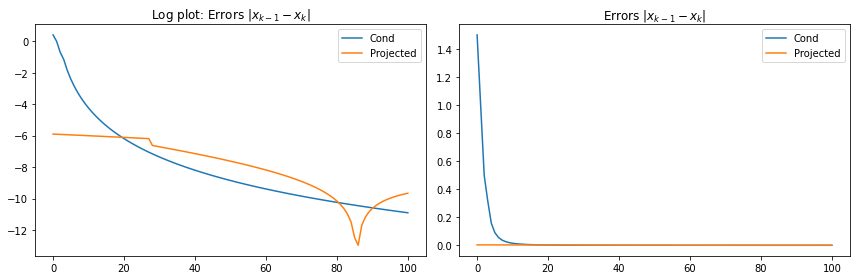

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.log(err_cond[1:]))
plt.plot(np.log(err_proj[1:]))
plt.legend(('Cond', 'Projected'))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
plt.plot(err_cond[1:])
plt.plot(err_proj[1:])
plt.legend(('Cond', 'Projected'))
plt.title(r'Errors $|x_{k-1}-x_{k}|$');

In [ ]:
print("Final Error: ", err_cond[-1], err_proj[-1])

Final Error:  1.8417458707972102e-05 6.356970403043061e-05


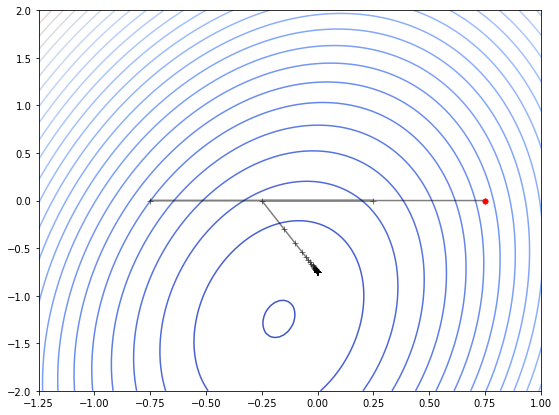

In [ ]:
t = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(t, t)
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = P(np.array([X[i,j], Y[i,j]]))
# Z = np.reshape(Z, X.shape)
plt.figure(figsize=(9, 7))
plt.contour(X, Y, Z, 50, cmap='coolwarm');
plt.plot(iter_cond[:,0], iter_cond[:, 1], marker = '+', color = 'k', alpha=0.5)
plt.plot(iter_cond[0,0], iter_cond[0,1], marker='.', markersize=10, color='r')
plt.xlim(np.min(iter_cond[:,0])-0.5, np.max(iter_cond[:,1])+1);